# FAST'26 Artifact Evaluation - Plotter

In [8]:
# Prelude
# RUN THIS CELL BEFORE ANYTHING ELSE!

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
import os
import re

cwd = os.getcwd().split("/scripts")[0]
os.chdir(cwd)

# the process function for PipeANN and DiskANN.
# Input: the raw log file
# Output: a dict with key: system + dataset, value: 
# {
#  "search": [(time, p50, p90, p99, tput)], 
#  "acc": { "L0": [acc1, acc2, ...], "L1": [acc1, acc2, ...] }, 
#  "mem": {(time, mem) } 
# }
# In the file, each line contains:
# 1. [xxx (DO NOT USE THIS TO IDENTIFY)] search current time: {time}
# 2. ten numbers, L, QPS, mean lat, p50, p90, p95, p99, p999, recall, diskIO
# - if recall == 0 and L equal to default_L, then add to "search".
# - elif recall == 0, ignore it.
# - else, add to "acc" with the corresponding "L" key.
# - recall should / 100 (float).
# 3. [xxx (DO NOT USE THIS TO IDENTIFY)] memory current time: 16 RSS : 1.50359e+07 KB
# - add this to "mem" (convert to GB)
# 4. other, ignore it.
# If process errors, then output the error line and pause.
def process_pipeann(filename, default_L):
    current_data = {
        "search": [],
        "acc": {},
        "mem": [],
        "insert_tput": [],
        "disk_space": 0
    }

    last_search_op_time = 0.0
    search_time_delta = 0 # we reboot DiskANN after each merge, so add the offset.

    cur_truth_file = ""
    truth_set = {}

    with open(filename, "r") as f:
        for line_num, line_content in enumerate(f, 1):
            line = line_content.strip()
            if not line: 
                continue
            
            # memory current time: 29 RSS : 1.02154e+07 KB /mnt/nvme/indices/deep/100M_shadow_disk.index Index size 79404 MB
            if "Index size" in line:
                idx_size = line.split("Index size")[1].strip().split()[0]
                current_data["disk_space"] = max(current_data["disk_space"], float(idx_size) / 1024) # MB to GB
            
            if "search current time:" in line:
                time_str = line.split("search current time:")[1].strip()
                if float(time_str) < last_search_op_time:
                    search_time_delta += last_search_op_time
                last_search_op_time = float(time_str)
                continue

            elif "memory current time:" in line and "RSS" in line:
                parts = line.split("memory current time:")[1].split("RSS :")
                mem_time_str = parts[0].strip()
                rss_kb_str = parts[1].split("KB")[0].strip()
                
                mem_time = float(mem_time_str)
                rss_kb = float(rss_kb_str)
                rss_gb = rss_kb / (1024 * 1024) # KB 到 GB
                current_data["mem"].append((mem_time + search_time_delta, rss_gb))
                continue
            elif "Reading truthset file" in line:
                cur_truth_file = line.split()[-1]
            elif "tasks/sec" in line and "Processed" in line:
                # Example line: Processed 4547 tasks, throughput: 909.217 tasks/sec.
                # filter out throughput.
                tput = line.split("throughput:")[-1].strip().split()[0]
                current_data["insert_tput"].append(float(tput))
            else:
                try:
                    data_parts = line.split()
                    if len(data_parts) == 10:
                        values = [float(p) for p in data_parts]
                        
                        L_val = int(values[0])
                        QPS_val = values[1]
                        p50_val = values[3]
                        p90_val = values[4]
                        p99_val = values[6]
                        recall_val = values[8]
                        n_pages = values[9]

                        if recall_val == 0:
                            if L_val == default_L:
                                if last_search_op_time is not None:
                                    current_data["search"].append(
                                        (last_search_op_time + search_time_delta, p50_val, p90_val, p99_val, QPS_val)
                                    )
                        else:
                            acc_value_float = recall_val / 100.0
                            acc_key = f"L{L_val}"
                            if acc_key not in current_data["acc"]:
                                current_data["acc"][acc_key] = []
                                current_data["acc"][acc_key + "_pages"] = []
                                current_data["acc"][acc_key + "_lat"] = []
                            # add cur_truth_file to the truth set.
                            if acc_key not in truth_set:
                                truth_set[acc_key] = set()
                            if cur_truth_file not in truth_set[acc_key]:
                                truth_set[acc_key].add(cur_truth_file)
                                current_data["acc"][acc_key].append(acc_value_float)
                                current_data["acc"][acc_key+"_pages"].append(n_pages)
                                current_data["acc"][acc_key+"_lat"].append(p50_val)
                        
                        continue
                except:
                    continue

    return current_data

# the process function for SPANN.
# Input: the raw log file
# Output: a dict with key: system + dataset + threads, value: list of latency, throughput and recall.
def process_spann(filename, L):
    sec_search = []
    sec_memory = []
    acc = []
    disk_space = 0

    def rdln(f):
        ret = f.readline()
        if not ret: # Handle EOF
            return None
        return ret.strip()

    ret = {}
    with open(filename, "r") as f:
        cur_sec = 0
        cur_truthset = ""
        while f:
            line = rdln(f)
            if line is None:
                break
            line = line.strip()
            split_line = line.split()

            if line.startswith("[1] Current time:") and "Searching Times" in line:
                tput_item = [int(split_line[3][:-1]), float(split_line[-1][:-1])] # qps
                lat_item = []
                while True:
                    line = rdln(f)
                    if "Total Latency Distribution" in line:
                        while True:
                            line = rdln(f)
                            try:
                                split_line = line.split()
                                if len(split_line) == 8:
                                    lat_item = [float(split_line[2]), float(split_line[3]), float(split_line[5])] # 50p, 90p, 99p
                                else:
                                    continue
                                break
                            except:
                                pass
                        break
                item = [tput_item[0]] + lat_item + [tput_item[1]] # time, p50, p90, p99, tput
                sec_search.append(item)
            elif line.startswith("[1] Current time"):
                cur_sec = int(split_line[3][:-1])
                sec_memory.append((int(split_line[3][:-1]) / 1000, int(split_line[-2]) / 1000))
            elif line.startswith("[1] Remain"):
                disk_space = max(disk_space, 1700 - int(split_line[-2]))
            elif "Recall10@10" in line:
                acc.append(float(split_line[-1])) # recall in percentage, convert to float

    ret = {
        "search": sec_search,
        "acc": {
            f"L{L}": acc
        },
        "mem": sec_memory,
        "disk_space": disk_space,
    }
    return ret

def downsample_median(x_data, y_data_list_input, max_npts):
    x_data = np.array(x_data) # 确保是numpy数组

    y_data_list = []
    if not isinstance(y_data_list_input, list):
        y_data_list = [np.array(y_data_list_input)] # 如果是单个数组，包装成列表
    else:
        for y_d in y_data_list_input:
            y_data_list.append(np.array(y_d)) # 确保列表中的每个元素都是numpy数组

    n_points = len(x_data)

    if n_points == 0 or max_npts is None or max_npts <= 0 or n_points <= max_npts:
        return x_data, y_data_list # 无需下采样或数据不足

    # 计算块大小和块数量
    chunk_size = math.ceil(n_points / max_npts)
    chunk_size = max(1, int(chunk_size)) # 确保块大小至少为1

    x_downsampled_list = []
    y_downsampled_lists_of_lists = [[] for _ in y_data_list]

    for i in range(0, n_points, chunk_size):
        start_idx = i
        end_idx = min(i + chunk_size, n_points)

        if start_idx >= end_idx: # 应该不会发生，除非n_points=0（已处理）
            continue

        x_chunk = x_data[start_idx:end_idx]
        x_downsampled_list.append(np.median(x_chunk))

        for j, y_data_single_series in enumerate(y_data_list):
            y_chunk = y_data_single_series[start_idx:end_idx]
            y_downsampled_lists_of_lists[j].append(np.median(y_chunk))
            
    x_downsampled_arr = np.array(x_downsampled_list)
    y_downsampled_list_result = [np.array(y_l) for y_l in y_downsampled_lists_of_lists]
            
    return x_downsampled_arr, y_downsampled_list_result

def plot_performance_dashboard(fig, axs, data, default_L, system_label, line_color, max_npts=None, lat_max = 15, tput_max = 7000, acc_max = 0.9, mem_max = 70):
    search_data = data.get("search", [])
    acc_data_all = data.get("acc", {})
    mem_data = data.get("mem", [])

    # 提取原始数据
    times_search_orig = np.array([item[0] for item in search_data]) if search_data else np.array([])
    p50_lat_orig = np.array([item[1] for item in search_data]) if search_data else np.array([])
    p90_lat_orig = np.array([item[2] for item in search_data]) if search_data else np.array([])
    p99_lat_orig = np.array([item[3] for item in search_data]) if search_data else np.array([])
    throughputs_orig = np.array([item[4] for item in search_data]) if search_data else np.array([])

    # 下采样搜索数据
    if times_search_orig.size > 0:
        times_search, y_search_ds_list = downsample_median(
            times_search_orig,
            [p50_lat_orig, p90_lat_orig, p99_lat_orig, throughputs_orig],
            max_npts
        )
        p50_lat, p90_lat, p99_lat, throughputs = y_search_ds_list[0], y_search_ds_list[1], y_search_ds_list[2], y_search_ds_list[3]
    else:
        times_search, p50_lat, p90_lat, p99_lat, throughputs = \
            times_search_orig, p50_lat_orig, p90_lat_orig, p99_lat_orig, throughputs_orig


    # (a) Search P50 Latency
    ax = axs[0, 0]
    if times_search.size > 0:
        ax.plot(times_search, p50_lat, color=line_color, label=system_label)
    ax.set_title("(a) Search P50 Latency")
    ax.set_xlabel("Elapsed Time (s)")
    ax.set_ylabel("Latency (ms)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.set_ylim(0, lat_max)
    ax.grid(True, linestyle='--', alpha=0.7)

    # (b) Search P90 Latency
    ax = axs[0, 1]
    if times_search.size > 0:
        ax.plot(times_search, p90_lat, color=line_color, label=system_label)
    ax.set_title("(b) Search P90 Latency")
    ax.set_xlabel("Elapsed Time (s)")
    ax.set_ylabel("Latency (ms)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.set_ylim(0, lat_max)
    ax.grid(True, linestyle='--', alpha=0.7)

    # (c) Search P99 Latency
    ax = axs[0, 2]
    if times_search.size > 0:
        ax.plot(times_search, p99_lat, color=line_color, label=system_label)
    ax.set_title("(c) Search P99 Latency")
    ax.set_xlabel("Elapsed Time (s)")
    ax.set_ylabel("Latency (ms)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.set_ylim(0, lat_max)
    ax.grid(True, linestyle='--', alpha=0.7)

    # (d) Search Throughput
    ax = axs[1, 0]
    if times_search.size > 0:
        ax.plot(times_search, throughputs, color=line_color, label=system_label)
    ax.set_title("(d) Search Throughput")
    ax.set_xlabel("Elapsed Time (s)")
    ax.set_ylabel("Throughput (Op/s)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}'))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.set_ylim(0, tput_max)
    ax.grid(True, linestyle='--', alpha=0.7)

    # (e) Search Accuracy
    ax = axs[1, 1]
    acc_key = f"L{default_L}"
    acc_values_orig = np.array(acc_data_all.get(acc_key, []))
    # X轴是 "Vectors Inserted (M)"，这里我们用acc值的索引作为代理
    vectors_inserted_m_orig = np.arange(len(acc_values_orig))

    if acc_values_orig.size > 0:
        vectors_inserted_m, acc_values_ds_list = downsample_median(
            vectors_inserted_m_orig,
            [acc_values_orig], # 将单个数组包装在列表中
            max_npts
        )
        acc_values = acc_values_ds_list[0] # 从列表中提取下采样后的数组
        ax.plot(vectors_inserted_m, acc_values, color=line_color, label=system_label)
    # else: # 如果没有准确度数据，acc_values_orig.size 会是0，不会进入绘图
    
    ax.set_title("(e) Search Accuracy")
    ax.set_xlabel("Vectors Inserted (M)") # 或 "Measurement Index"
    ax.set_ylabel(f"Recall @10")
    ax.set_ylim(0, acc_max)
    ax.grid(True, linestyle='--', alpha=0.7)

    # (f) Memory Usage
    ax = axs[1, 2]
    times_mem = np.array([]) # 初始化以防没有内存数据
    mem_usage_gb = np.array([])
    if mem_data:
        sorted_mem_data = sorted(mem_data, key=lambda x: x[0])
        times_mem_orig = np.array([item[0] for item in sorted_mem_data])
        mem_usage_gb_orig = np.array([item[1] for item in sorted_mem_data])

        if times_mem_orig.size > 0:
            times_mem, mem_usage_gb_ds_list = downsample_median(
                times_mem_orig,
                [mem_usage_gb_orig], # 将单个数组包装在列表中
                max_npts
            )
            mem_usage_gb = mem_usage_gb_ds_list[0] # 从列表中提取下采样后的数组
            ax.plot(times_mem, mem_usage_gb, color=line_color, label=system_label)
    # else: # 如果没有内存数据，times_mem.size 会是0，不会进入绘图
            
    ax.set_title("(f) Memory Usage")
    ax.set_xlabel("Elapsed Time (s)")
    ax.set_ylabel("Memory (GB)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.set_ylim(0, mem_max)
    ax.grid(True, linestyle='--', alpha=0.7)

sysname = [
    "OdinANN",
    "DiskANN",
    "SPFresh"
]

colors = [
    "red",
    "blue",
    "purple"
]

## Figure 6

This figure requires that you run `fig6.sh` beforehand.

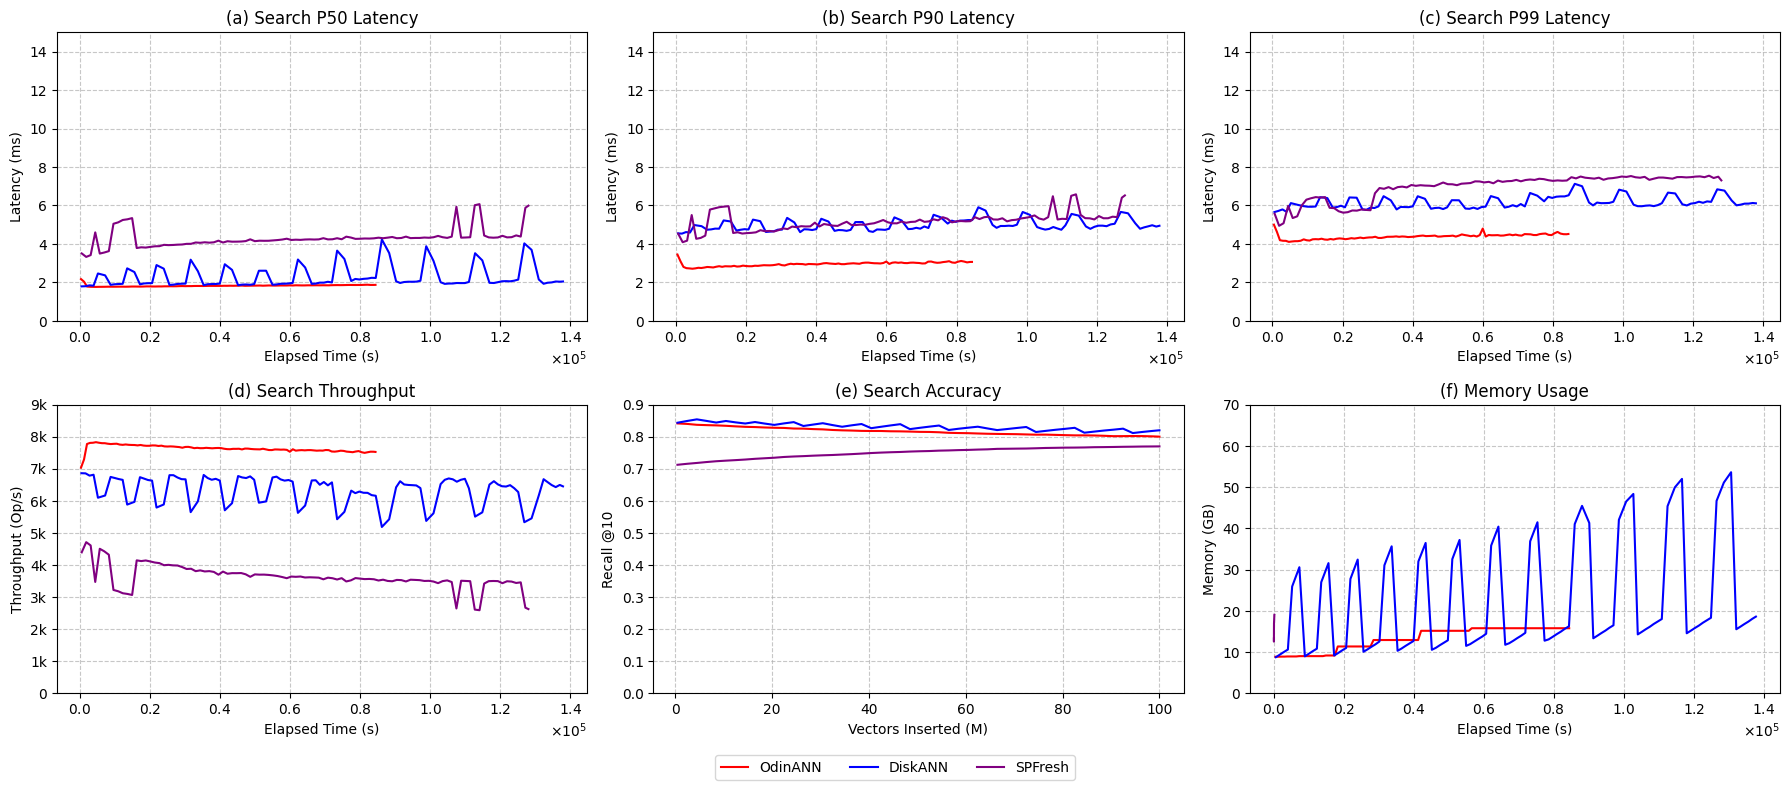

In [9]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L = 20

data = [
    process_pipeann(filename_prefix + "/OdinANN-insertonly-sift.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/DiskANN-insertonly-sift.txt", DEFAULT_L),
    process_spann(filename_prefix + "/SPFresh-insertonly-sift.txt", DEFAULT_L)
]

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
for name, parsed_data, color in zip(sysname, data, colors):
    plot_performance_dashboard(fig, axs, parsed_data, DEFAULT_L, name, color, 100, 15, 9000, 0.9, 70)

handles, labels = [], []
for ax_row in axs:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        for i, label_item in enumerate(l):
            if label_item not in labels: # 确保每个标签只添加一次
                labels.append(label_item)
                handles.append(h[i])

if handles: # 仅当有要显示的内容时才添加图例
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局以适应图例和可能的总标题



## Figure 7

This figure requires that you run `fig7.sh` beforehand.

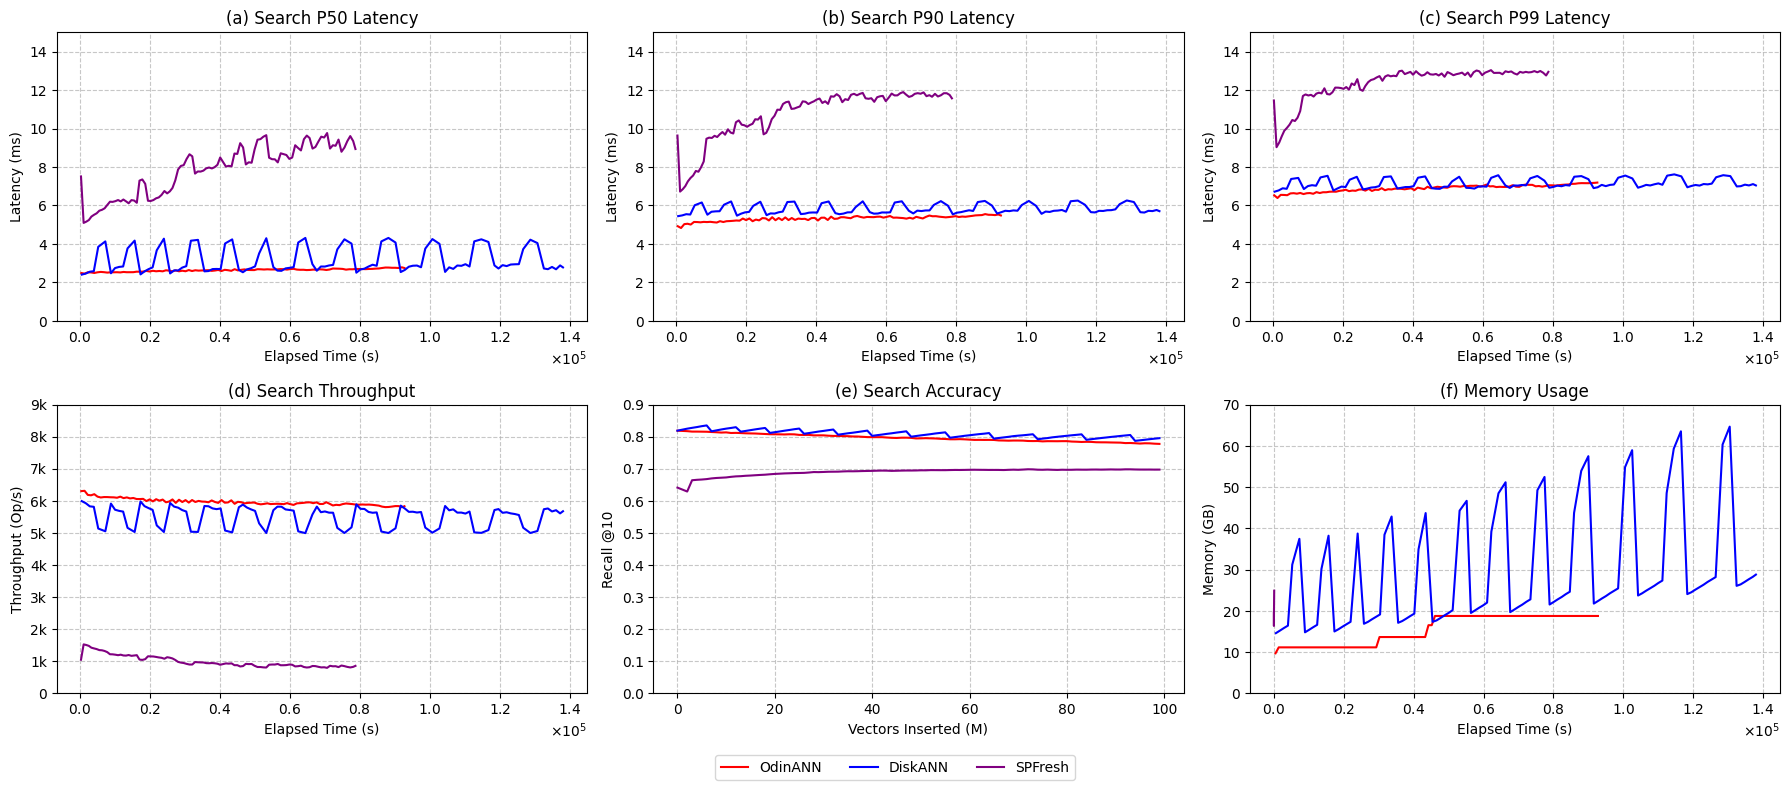

In [10]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L = 25

data = [
    process_pipeann(filename_prefix + "/OdinANN-insertonly-deep.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/DiskANN-insertonly-deep.txt", DEFAULT_L),
    process_spann(filename_prefix + "/SPFresh-insertonly-deep.txt", DEFAULT_L)
]

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
for name, parsed_data, color in zip(sysname, data, colors):
    plot_performance_dashboard(fig, axs, parsed_data, DEFAULT_L, name, color, 100, 15, 9000, 0.9, 70)

handles, labels = [], []
for ax_row in axs:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        for i, label_item in enumerate(l):
            if label_item not in labels: # 确保每个标签只添加一次
                labels.append(label_item)
                handles.append(h[i])

if handles: # 仅当有要显示的内容时才添加图例
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局以适应图例和可能的总标题

## Figure 8

This figure requires that you run `fig8.sh` beforehand.

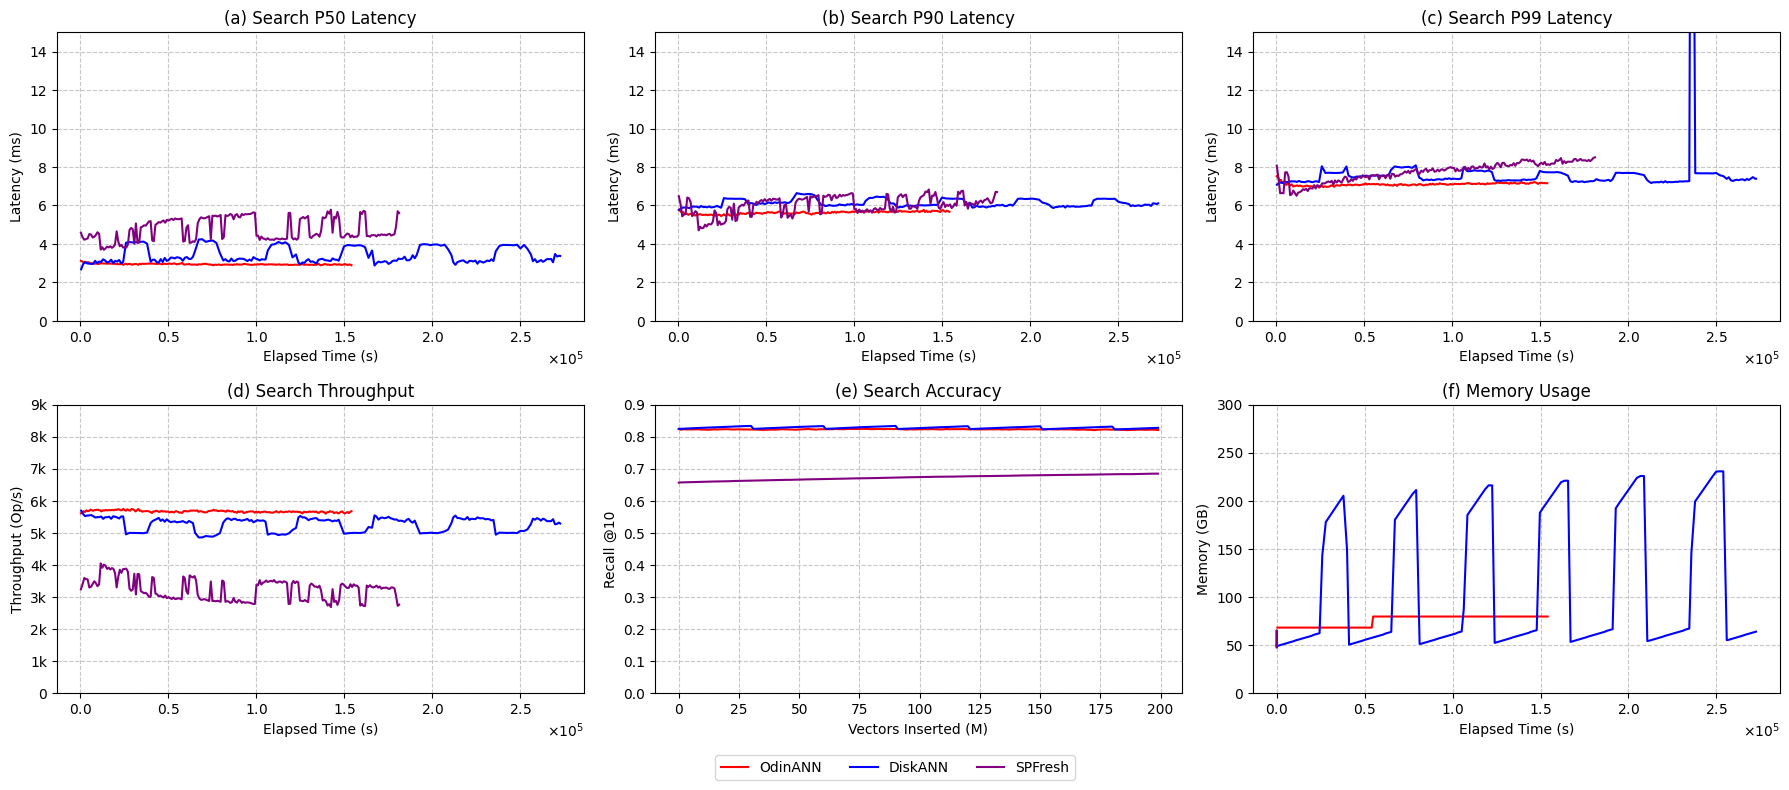

In [11]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L = 25

data = [
    process_pipeann(filename_prefix + "/OdinANN-stress.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/DiskANN-stress.txt", DEFAULT_L),
    process_spann(filename_prefix + "/SPFresh-stress.txt", DEFAULT_L)
]

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
for name, parsed_data, color in zip(sysname, data, colors):
    plot_performance_dashboard(fig, axs, parsed_data, DEFAULT_L, name, color, 200, 15, 9000, 0.9, 300)

handles, labels = [], []
for ax_row in axs:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        for i, label_item in enumerate(l):
            if label_item not in labels: # 确保每个标签只添加一次
                labels.append(label_item)
                handles.append(h[i])

if handles: # 仅当有要显示的内容时才添加图例
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局以适应图例和可能的总标题

## Figure 9

This figure requires that you run `fig9.sh` beforehand.

/tmp/ipykernel_2339905/2095323922.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black', linewidth=0.5) for color in colors]


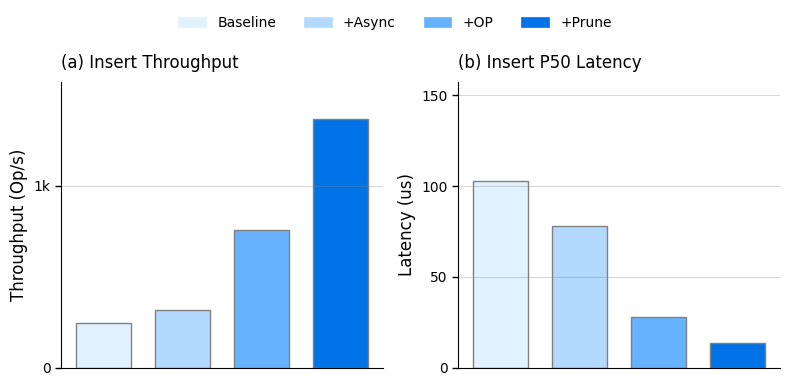

In [14]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"

def process_file(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    tput = 0
    p50_lat = 0
    for line in lines:
        if "Inserted" in line and "points in" in line:
            parts = line.split("Inserted")[1].split()
            num_points = int(parts[0])
            time_taken = float(parts[3][:-1])
            tput = num_points / time_taken
        elif "50p insertion time :" in line:
            p50_lat = float(line.split()[-2]) / 1000
    return (tput, p50_lat)

data = [
    process_file(filename_prefix + "/Baseline-insertonly-sift.txt"),
    process_file(filename_prefix + "/Async-insertonly-sift.txt"),
    process_file(filename_prefix + "/Op-insertonly-sift.txt"),
    process_file(filename_prefix + "/Prune-insertonly-sift.txt")
]

throughputs = [item[0] for item in data]
p50_latencies = [item[1] for item in data]
categories = ['Baseline', '+Async', '+OP', '+Prune']
colors = ['#E0F2FF', '#B3D9FF', '#66B2FF', '#0073E6'] # Light to dark blue
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # 1 row, 2 columns

bar_width = 0.7 # Width of the bars
x_positions = np.arange(len(categories))
ax1.bar(x_positions, throughputs, width=bar_width, color=colors, edgecolor='grey')
ax1.set_ylabel('Throughput (Op/s)', fontsize=12)
ax1.set_title('(a) Insert Throughput', fontsize=12, loc='left', pad=10) # loc and pad for positioning

ax1.set_xticks(x_positions)
ax1.set_xticklabels([]) # Remove x-tick labels for the top legend style
ax1.set_yticks([0, 1000, 2000])
ax1.set_yticklabels(['0', '1k', '2k'], fontsize=10)
ax1.set_ylim(0, max(throughputs) * 1.15) # Add some padding at the top

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='y', direction='out', length=4, width=1)
ax1.tick_params(axis='x', length=0) # Hide x-axis ticks lines
ax1.grid(axis='y', linestyle='-', alpha=0.3, color='grey') # Fainter grid lines

ax2.bar(x_positions, p50_latencies, width=bar_width, color=colors, edgecolor='grey')
ax2.set_ylabel('Latency (us)', fontsize=12)
ax2.set_title('(b) Insert P50 Latency', fontsize=12, loc='left', pad=10)

ax2.set_xticks(x_positions)
ax2.set_xticklabels([]) # Remove x-tick labels for the top legend style

ax2.set_yticks([0, 50, 100, 150])
ax2.set_yticklabels(['0', '50', '100', '150'], fontsize=10)
ax2.set_ylim(0, 150 * 1.05) # Add some padding at the top, ensure 150 is visible

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', direction='out', length=4, width=1)
ax2.tick_params(axis='x', length=0) # Hide x-axis ticks lines
ax2.grid(axis='y', linestyle='-', alpha=0.3, color='grey') # Fainter grid lines

legend_handles = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black', linewidth=0.5) for color in colors]
fig.legend(legend_handles, categories, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(categories), frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.93]) # rect=[left, bottom, right, top]

# Show the plot
plt.show()

## Figure 10

This figure requires that you run `fig6.sh` and `fig7.sh` beforehand.

In [13]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L_SIFT = 20
DEFAULT_L_DEEP = 25

data_sift = [
    process_pipeann(filename_prefix + "/OdinANN-insertonly-sift.txt", DEFAULT_L_SIFT),
    process_pipeann(filename_prefix + "/DiskANN-insertonly-sift.txt", DEFAULT_L_SIFT),
    process_spann(filename_prefix + "/SPFresh-insertonly-sift.txt", DEFAULT_L_SIFT)
]

data_deep = [
    process_pipeann(filename_prefix + "/OdinANN-insertonly-deep.txt", DEFAULT_L_DEEP),
    process_pipeann(filename_prefix + "/DiskANN-insertonly-deep.txt", DEFAULT_L_DEEP),
    process_spann(filename_prefix + "/SPFresh-insertonly-deep.txt", DEFAULT_L_DEEP)
]

disk_space_sift = [
    data_sift[0]["disk_space"],
    55 * 2,
    data_sift[2]["disk_space"],
    83 * 2
]

disk_space_deep = [
    data_deep[0]["disk_space"],
    77 * 2,
    data_deep[2]["disk_space"],
    226 * 2
]

recall_pages = []

for i in range(2):
    cur = []
    for k, v in data_deep[i]["acc"].items():
        if k.endswith("_pages"):
            continue
        cur.append((v[94], data_deep[i]["acc"][k + "_pages"][94]))
    recall_pages.append(cur)

import matplotlib.patches as mpatches # For custom legend handles
from matplotlib.lines import Line2D # For custom legend line handles
odin_ann_recall = [item[0] for item in recall_pages[0]]
odin_ann_pages = [item[1] for item in recall_pages[0]]
disk_ann_recall = [item[0] for item in recall_pages[1]]
disk_ann_pages = [item[1] for item in recall_pages[1]]

# --- Plotting Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) # Adjust figsize as needed

# --- Define styles based on the image ---
# Panel (a) bar styles
colors_bars = ['#d62728', '#1f77b4', '#4B0082', '#A289C0'] # Red, Blue, DarkPurple, LightPurple
# Hatches: '/', '-', 'x', '' (no hatch for SPFresh-ideal)
# Note: Matplotlib hatch color is determined by edgecolor or can be set separately in newer versions.
# We'll use edgecolor for simplicity.
hatches_bars = ['/', '-', 'x', '']
bar_labels_a = ['OdinANN', 'OdinANN-ideal', 'SPFresh', 'SPFresh-ideal']

# Panel (b) line styles
colors_lines = ['#d62728', '#1f77b4'] # Red, Blue
markers_lines = ['o', 's']
line_labels_b = ['OdinANN', 'DiskANN']


# --- Plot (a): Disk Size ---
datasets_a = ['SIFT', 'DEEP']
num_datasets_a = len(datasets_a)
num_methods_a = len(bar_labels_a)
bar_width_a = 0.18  # Width of individual bars
group_width_a = bar_width_a * num_methods_a
x_a = np.arange(num_datasets_a) # Positions for SIFT, DEEP groups

for i in range(num_methods_a):
    # Calculate bar positions for each method within the group
    # Offset formula: x_group_center + (bar_index - num_bars_in_group / 2 + 0.5) * bar_width
    bar_positions = x_a + (i - num_methods_a / 2 + 0.5) * bar_width_a
    values = [disk_space_sift[i], disk_space_deep[i]]
    ax1.bar(bar_positions, values, width=bar_width_a,
            color=colors_bars[i], hatch=hatches_bars[i],
            edgecolor='black', linewidth=0.7, zorder=3) # zorder to bring bars above grid

ax1.set_ylabel('Disk size (GB)', fontsize=12)
ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_title('(a)', loc='left', fontsize=12, pad=10)
ax1.set_xticks(x_a)
ax1.set_xticklabels(datasets_a, fontsize=10)
ax1.set_yticks(np.arange(0, 801, 200))
ax1.set_yticklabels([str(int(t)) for t in np.arange(0, 801, 200)], fontsize=10)
ax1.set_ylim(0, 850)

# Style ax1
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', direction='out', length=4, width=1)
ax1.grid(axis='y', linestyle='-', alpha=0.5, color='grey', zorder=0)


# --- Plot (b): Recall vs. Pages ---
ax2.plot(odin_ann_pages, odin_ann_recall, marker=markers_lines[0], color=colors_lines[0],
         label=line_labels_b[0], markersize=7, linewidth=2, zorder=3)
ax2.plot(disk_ann_pages, disk_ann_recall, marker=markers_lines[1], color=colors_lines[1],
         label=line_labels_b[1], markersize=7, linewidth=2, zorder=3)

ax2.set_ylabel('Recall 10@10', fontsize=12) # Assuming "10@10" is part of the label
ax2.set_xlabel('Average Pages Per Search', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12, pad=10)

ax2.set_xticks(np.arange(50, 71, 10))
ax2.set_xticklabels([str(int(t)) for t in np.arange(50, 71, 10)], fontsize=10)
ax2.set_yticks(np.arange(0.7, 0.91, 0.1))
ax2.set_yticklabels([f"{t:.1f}" for t in np.arange(0.7, 0.91, 0.1)], fontsize=10)
ax2.set_xlim(45, 70) # Adjusted based on image
ax2.set_ylim(0.68, 0.92) # Adjusted based on image

# Style ax2
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', direction='out', length=4, width=1)
ax2.grid(axis='y', linestyle='-', alpha=0.5, color='grey', zorder=0)


# --- Combined Legend (Figure Level) ---
# Create custom handles for the legend to match the image precisely
legend_handles = [
    mpatches.Patch(facecolor=colors_bars[0], hatch=hatches_bars[0], edgecolor='black', label=bar_labels_a[0]), # OdinANN bar
    mpatches.Patch(facecolor=colors_bars[2], hatch=hatches_bars[2], edgecolor='black', label=bar_labels_a[2]), # SPFresh bar
    mpatches.Patch(facecolor=colors_bars[1], hatch=hatches_bars[1], edgecolor='black', label=bar_labels_a[1]), # OdinANN-ideal bar
    mpatches.Patch(facecolor=colors_bars[3], hatch=hatches_bars[3], edgecolor='black', label=bar_labels_a[3]), # SPFresh-ideal bar
    Line2D([0], [0], marker=markers_lines[0], color=colors_lines[0], label=line_labels_b[0], linestyle='None', markersize=7), # OdinANN line
    Line2D([0], [0], marker=markers_lines[1], color=colors_lines[1], label=line_labels_b[1], linestyle='None', markersize=7)  # DiskANN line
]

# Order of labels in the image: OdinANN, OdinANN-ideal, OdinANN (line), SPFresh, SPFresh-ideal, DiskANN
# Let's reorder handles and labels to match this desired legend order if needed
# The image shows:
# Row 1: OdinANN (bar), OdinANN-ideal (bar), OdinANN (line)
# Row 2: SPFresh (bar), SPFresh-ideal (bar), DiskANN (line)

ordered_handles = [
    mpatches.Patch(facecolor=colors_bars[0], hatch=hatches_bars[0], edgecolor='black'), # OdinANN bar
    mpatches.Patch(facecolor=colors_bars[1], hatch=hatches_bars[1], edgecolor='black'), # OdinANN-ideal bar
    Line2D([0], [0], marker=markers_lines[0], color=colors_lines[0], linestyle='None', markersize=7), # OdinANN line
    mpatches.Patch(facecolor=colors_bars[2], hatch=hatches_bars[2], edgecolor='black'), # SPFresh bar
    mpatches.Patch(facecolor=colors_bars[3], hatch=hatches_bars[3], edgecolor='black'), # SPFresh-ideal bar
    Line2D([0], [0], marker=markers_lines[1], color=colors_lines[1], linestyle='None', markersize=7)  # DiskANN line
]
ordered_labels = [
    bar_labels_a[0],        # OdinANN
    bar_labels_a[1],        # OdinANN-ideal
    line_labels_b[0],       # OdinANN (for line)
    bar_labels_a[2],        # SPFresh
    bar_labels_a[3],        # SPFresh-ideal
    line_labels_b[1]        # DiskANN
]

fig.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), # Adjust y position in bbox_to_anchor
           ncol=3, frameon=False, fontsize=10, handletextpad=0.5, columnspacing=1.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.92]) # rect=[left, bottom, right, top] to make space for legend


KeyError: 'L25_lat_pages'

## Figure 11

This figure requires that you run `fig11.sh` beforehand.

/tmp/ipykernel_2339905/1851321609.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(R_values_str) # Ensure x-tick labels are present


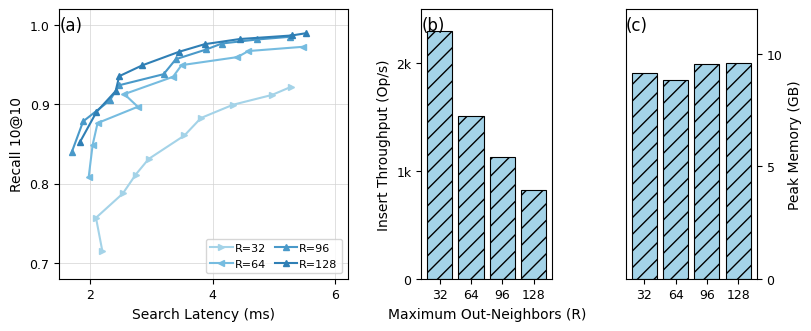

In [ ]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L = 20

data = [
    process_pipeann(filename_prefix + "/varl_L32.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/varl_L64.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/varl_L96.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/varl_L128.txt", DEFAULT_L),
]

# search latency.
recall_lat = []
for i in range(len(data)):
    cur = []
    for k, v in data[i]["acc"].items():
        if k.endswith("_pages") or k.endswith("_lat"):
            continue
        lat = data[i]["acc"][k + "_lat"]
        cur.append((sum(v) / len(v), sum(lat) / len(lat))) # index after update.
    recall_lat.append(cur)

insert_tput = [sum(x["insert_tput"]) / len(x["insert_tput"]) for x in data]
memory_usages = [x["mem"][-1][1] for x in data]


import matplotlib.gridspec as gridspec

R_values_numeric = [32, 64, 96, 128]
R_values_str = [str(r) for r in R_values_numeric]

# Plotting properties for (a)
markers = ['>', '<', '^', '^'] # R=32, R=64, R=96, R=128
# Colors extracted from the image legend (lightest to darkest blue)
plot_colors = ['#a4d3e8', '#76bce0', '#4999c9', '#2f7fb5']
legend_labels = [f'R={r}' for r in R_values_numeric]


# Create the figure and subplots using GridSpec for layout control
fig = plt.figure(figsize=(9, 3.5)) # Adjusted figure size
gs = gridspec.GridSpec(1, 3, width_ratios=[2.2, 1, 1], wspace=0.4) # Adjusted wspace

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Subplot (a): Recall vs. Latency
for i in range(len(recall_lat)):
    r_data = recall_lat[i]
    recalls = [item[0] for item in r_data]
    latencies = [item[1] for item in r_data]
    ax1.plot(latencies, recalls, marker=markers[i], color=plot_colors[i], label=legend_labels[i], markersize=5, linewidth=1.5)

ax1.set_xlabel('Search Latency (ms)', fontsize=10)
ax1.set_ylabel('Recall 10@10', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=12, y=1.0, pad=-15) # Position title similar to image

ax1.set_xticks([0, 2, 4, 6])
ax1.set_yticks([0.7, 0.8, 0.9, 1.0])
ax1.set_xlim([1.5, 6.2]) # Adjusted xlim to focus on data range
ax1.set_ylim([0.68, 1.02])
ax1.legend(loc='lower right', ncol=2, fontsize=8, columnspacing=0.8, handletextpad=0.2) # Adjusted legend
ax1.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
ax1.tick_params(axis='both', which='major', labelsize=9)

# Subplot (b): Insert Throughput
bar_color = plot_colors[0] # Using the lightest blue for bars
ax2.bar(R_values_str, insert_tput, color=bar_color, hatch='//', edgecolor='black', linewidth=0.8)
ax2.set_xlabel('Maximum Out-Neighbors (R)', fontsize=10)
ax2.set_ylabel('Insert Throughput (Op/s)', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=12, y=1.0, pad=-15)

ax2.set_yticks([0, 1000, 2000])
ax2.set_yticklabels(['0', '1k', '2k'])
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=9)


# Subplot (c): Peak Memory
ax3.bar(R_values_str, memory_usages, color=bar_color, hatch='//', edgecolor='black', linewidth=0.8)
# ax3 does not have its own x-label, it shares context with ax2
ax3.set_ylabel('Peak Memory (GB)', fontsize=10)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_title('(c)', loc='left', fontsize=12, y=1.0, pad=-15)

ax3.set_yticks([0, 5, 10])
ax3.set_ylim([0, 12]) # Adjusted ylim to give some space
ax3.set_xticklabels(R_values_str) # Ensure x-tick labels are present
ax3.tick_params(axis='both', which='major', labelsize=9)



## Figure 12

This figure requires that you run `fig12.sh` beforehand.

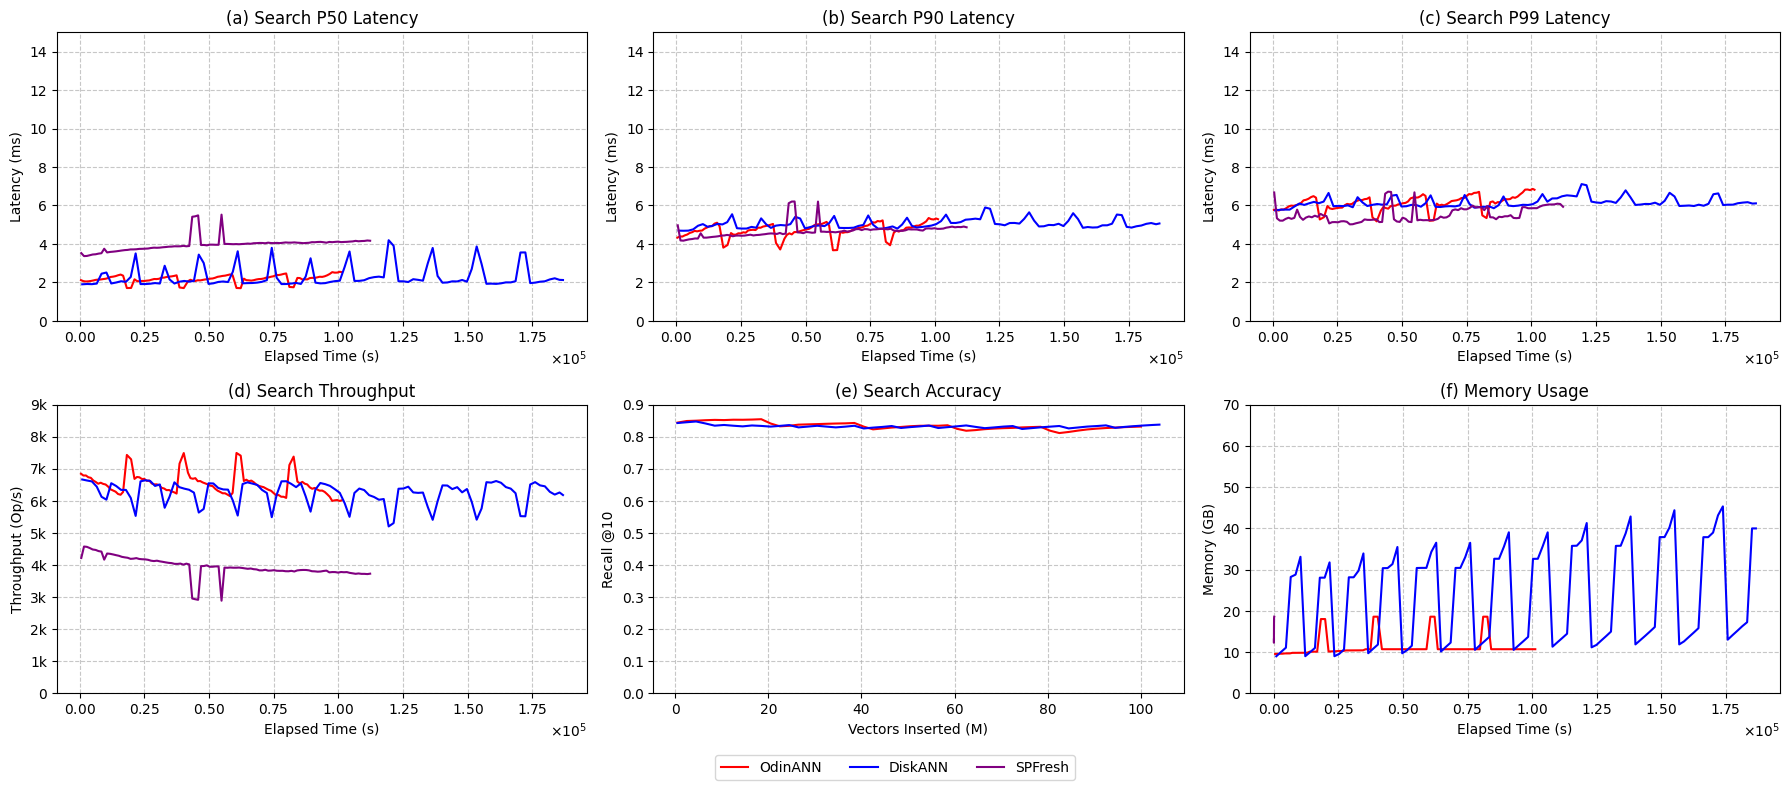

In [ ]:
USE_EXAMPLE = True
filename_prefix = "./data-example" if USE_EXAMPLE else "./data"
DEFAULT_L = 20

data = [
    process_pipeann(filename_prefix + "/OdinANN-workload-change.txt", DEFAULT_L),
    process_pipeann(filename_prefix + "/DiskANN-workload-change.txt", DEFAULT_L),
    process_spann(filename_prefix + "/SPFresh-workload-change.txt", DEFAULT_L)
]

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
for name, parsed_data, color in zip(sysname, data, colors):
    plot_performance_dashboard(fig, axs, parsed_data, DEFAULT_L, name, color, 100, 15, 9000, 0.9, 70)

handles, labels = [], []
for ax_row in axs:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        for i, label_item in enumerate(l):
            if label_item not in labels: # 确保每个标签只添加一次
                labels.append(label_item)
                handles.append(h[i])

if handles: # 仅当有要显示的内容时才添加图例
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局以适应图例和可能的总标题

